# Generating Monet-Style Images with a GAN

GitHub repository: https://github.com/niju789/GAN-Monet-Paintings

## 1 - Introduction

### 1.1 - Problem

This projects aims to develop and train a GAN that can generate images in the style of Monet from photographs.

### 1.2 - Generative Deep Learning Models

Generative deep learning models are models that use deep learning methods to generate various types of data such as numerical, text, image, and audio data, and many other types.

#### 1.2.1 - Generative Adversarial Networks (GANs)

A GAN is a specific type of generative deep learning model that consists of a generator and a discriminator. The generator, as the name suggests, generates data which is then evaluated by the discriminator. The evaluation of the discriminator is used to improve the generator so that the generator can generate data that the discriminator struggles to tell whether the data is real or generated.

### 1.3 - Data

The data provided consists of 7028 photographs and 300 Monet paintings. Each image is a 256 x 256 JPEG format image.

## 2 - Exploratory Data Analysis (EDA)

### 2.1 - Data Inspection

#### 2.1.1 - Sample Photographs

In [1]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Paths to image folder
photo_path = "/kaggle/input/gan-getting-started/photo_jpg"
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"

# Function to create an array from images loaded from a folder
def load_images(folder):
    images = []
    for img_file in os.listdir(folder):
        img = load_img(os.path.join(folder, img_file), target_size=(256, 256))
        # Normalize pixel values to between -1 and 1
        img = img_to_array(img) / 127.5 - 1
        images.append(img)
    return np.array(images)

In [2]:
# Load images from folders
photo_images = load_images(photo_path)
monet_images = load_images(monet_path)

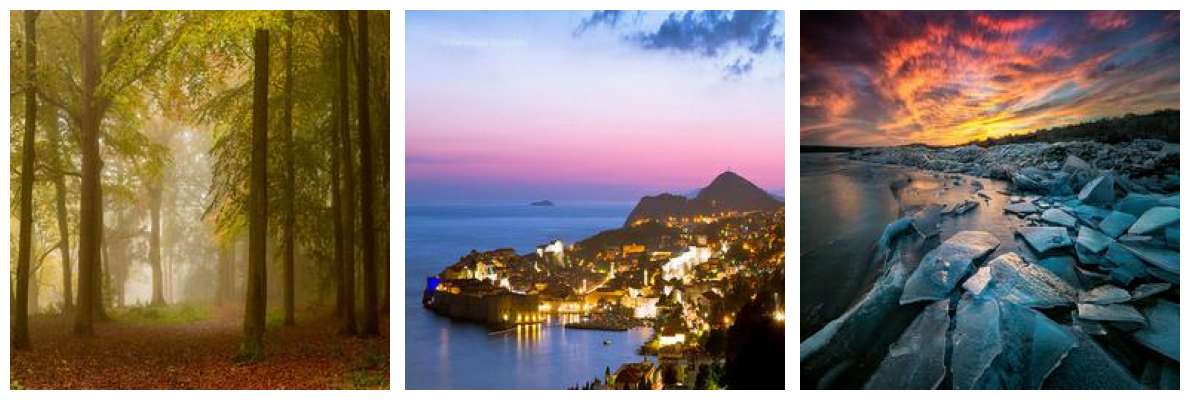

In [3]:
import matplotlib.pyplot as plt

# Function to display 3 sample images array of images
def display_samples(images):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    for i in range(3):
        ax[i].imshow(images[i] * 0.5 + 0.5)
        ax[i].axis("off")
    plt.tight_layout()
    plt.show()

display_samples(photo_images)

#### 2.1.2 - Sample Monet Paintings

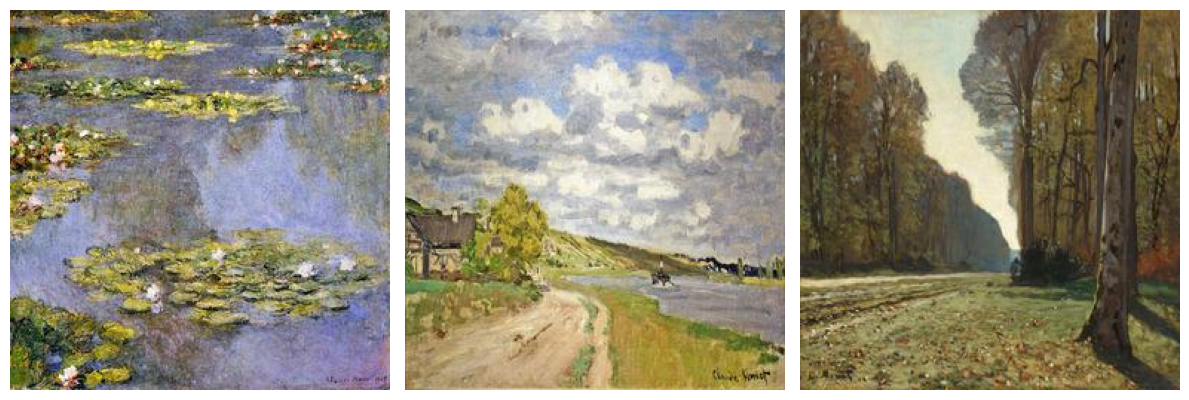

In [4]:
display_samples(monet_images)

#### 2.1.3 - Findings

Both the photograph and Monet painting sets seem to be depicting nature or sceneries. It is ideal that the photographs provided are of sceneries as this matches what is captured by the Monet paintings.

### 2.2 - Pixel Intensity Analysis

#### 2.2.1 - Visualizations

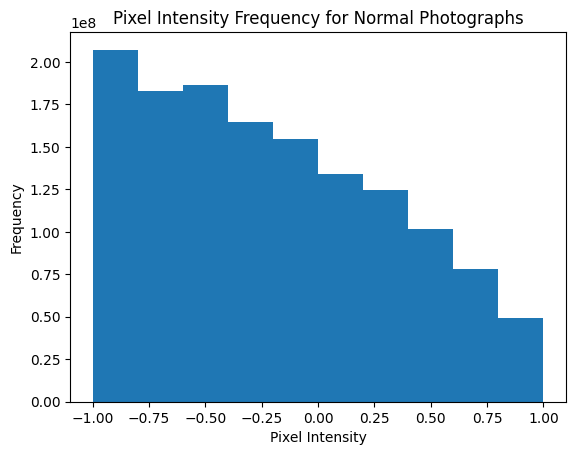

In [5]:
# Function to plot histogram of pixel intensity values
def plot_histogram(images, title):
    plt.hist(images.ravel())
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

plot_histogram(photo_images, "Pixel Intensity Frequency for Normal Photographs")

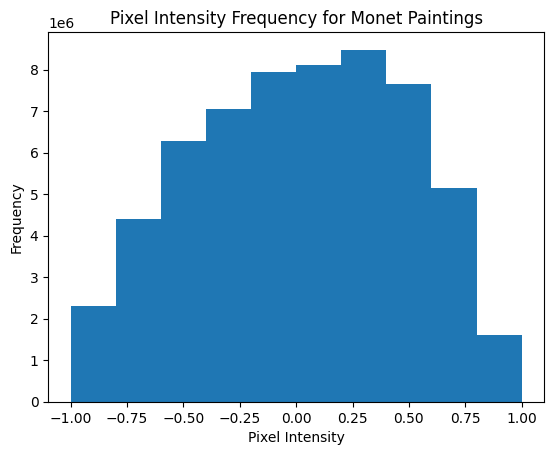

In [6]:
plot_histogram(monet_images, "Pixel Intensity Frequency for Monet Paintings")

#### 2.2.2 - Analysis Results

The pixel intensities for photographs are more skewed towards -1 compared to the Monet paintings. The pixel intensities for the Monet paintings appear to be more normally distributed than the photographs with mean around 0.25.

## 3 - Model Architecture

### 3.1 - Architectures Considered

Two different model architectures will be considered and compared.

#### 3.1.1 - Architecture 1

Generator: The generator takes as input an array of shape 256 x 256 x 3 since the input images have length and width of 256 pixels and 3 channels (RGB). The first layer is a convolutional layer with 16 filters and convolutional windows of 3 x 3 with a stride of 2. The ReLU activation function and a batch normalization layer is then used. A deconvolutional layer with the same properties of the initial convolutional layer follows. The ReLU activation function and a batch normalization layer is then used again. The final layer is a convolutional layer with 3 filters for each of the RGB channels, a stride of 1, and a Tanh activation function so that the output is between -1 to 1 as expected for pixel intensities.

Discriminator: The discriminator takes as input an array of shape 256 x 256 x 3 since the input images have length and width of 256 pixels and 3 channels (RGB). The first layer is a convolutional layer with 16 filters and convolutional windows of 3 x 3 with a stride of 2. The ReLU activation function is then used. This is followed by a dropout layer that drops 50% of the parameters so far in the model. Then, a convolutional layer with the same properties as the initial convolutional layer is used. Followed again by ReLU activation and dropout of 50%. Then a flattening layer is used, followed by a fully connected layer with 1 neuron. Finally, the Sigmoid activation function is used so that the output is between 0 and 1 as expected for binary classification.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Conv2DTranspose, Dropout, Flatten, Dense

# Returns generator and discriminator of architecture 1
def build_gan_1():
    generator = Sequential([
        Input(shape=(256, 256, 3)),
        Conv2D(16, kernel_size=3, strides=2, padding="same"),
        ReLU(),
        BatchNormalization(),
        Conv2DTranspose(16, kernel_size=3, strides=2, padding="same"),
        ReLU(),
        BatchNormalization(),
        Conv2D(3, kernel_size=3, activation="tanh", padding="same")
    ])
    
    discriminator = Sequential([
        Input(shape=(256, 256, 3)),
        Conv2D(16, kernel_size=3, strides=2, padding="same"),
        ReLU(),
        Dropout(0.5),
        Conv2D(16, kernel_size=3, strides=2, padding="same"),
        ReLU(),
        Dropout(0.5),
        Flatten(),
        Dense(1, activation="sigmoid")
    ])

    return generator, discriminator

#### 3.1.2 - Architecture 2

This architecture is similar to the previous architecture. The difference being the use of layer nomalization instead of batch normalization in the generator and a dropout rate of 25% in the discriminator.

In [8]:
from tensorflow.keras.layers import LayerNormalization

# Returns generator and discriminator of architecture 2
def build_gan_2():
    generator = Sequential([
        Input(shape=(256, 256, 3)),
        Conv2D(16, kernel_size=3, strides=2, padding="same"),
        ReLU(),
        LayerNormalization(),
        Conv2DTranspose(16, kernel_size=3, strides=2, padding="same"),
        ReLU(),
        LayerNormalization(),
        Conv2D(3, kernel_size=3, activation="tanh", padding="same")
    ])
    
    discriminator = Sequential([
        Input(shape=(256, 256, 3)),
        Conv2D(16, kernel_size=3, strides=2, padding="same"),
        ReLU(),
        Dropout(0.25),
        Conv2D(16, kernel_size=3, strides=2, padding="same"),
        ReLU(),
        Dropout(0.25),
        Flatten(),
        Dense(1, activation="sigmoid")
    ])

    return generator, discriminator

### 3.2 - Hyperparameter Tuning

Due to limited resources in terms of computing power and time, the hyperparameters that will be considered are those involved in training a neural network. The hyperparameters that will be tuned are the number of epochs and batch size. For both architectures, 5 and 10 will be considered as values for the number of epochs and 16 and 32 as values for the batch size.

#### 3.2.1 - Architecture 1

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import ParameterGrid

# Compiles and returns GAN model
def compile_gan(generator, discriminator):
    discriminator.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"])
    gan_input = Input(shape=(256, 256, 3))
    fake_image = generator(gan_input)
    gan_output = discriminator(fake_image)
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=Adam(0.001), loss="binary_crossentropy")
    return gan

def train_gan(generator, discriminator, gan, images, epochs, batch_size):
    print(f"Epochs: {epochs}, Batch size: {batch_size}")
    
    for epoch in range(epochs):
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_images = images[idx]
        fake_images = generator.predict(real_images)
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        g_loss = gan.train_on_batch(real_images, real_labels)

    print(f"Training completed, D Loss: {d_loss_real[0]}, G Loss: {g_loss[0]}")

param_grid = ParameterGrid({"epochs": [5, 10], "batch_size": [16, 32]})

In [10]:
for params in param_grid:
    generator, discriminator = build_gan_1()
    gan = compile_gan(generator, discriminator)
    train_gan(generator, discriminator, gan, photo_images, epochs=params['epochs'], batch_size=params['batch_size'])

Epochs: 5, Batch size: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Training completed, D Loss: 1.2424261569976807, G Loss: 1.265506625175476
Epochs: 10, Batch size: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training completed, D Loss: 0.5642783045768738, G Loss: 0.5741691589355469
Epochs: 5, Batch size: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386

#### 3.2.2 - Architecture 2

In [11]:
for params in param_grid:
    generator, discriminator = build_gan_2()
    gan = compile_gan(generator, discriminator)
    train_gan(generator, discriminator, gan, photo_images, epochs=params['epochs'], batch_size=params['batch_size'])

Epochs: 5, Batch size: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Training completed, D Loss: 3.3868064880371094, G Loss: 3.0758633613586426
Epochs: 10, Batch size: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
Training completed, D Loss: 1.6690754890441895, G Loss: 1.6522849798202515
Epochs: 5, Batch size: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 66

## 4 - Results and Analysis

### 4.1 - Hyperparameter Tuning Summary

#### 4.1.1 - Architecture 1

Loss values:

|| 16 Batch Size | 32 Batch Size |
| :-: | :-: | :-: |
| **5 Epochs** | 1.242 | 0.671 |
| **10 Epochs** | 0.564 | 1.156 |

10 epochs and batch size of 16 resulted in the lowest loss value of 0.564.

#### 4.1.2 - Architecture 2

Loss values:

|| 16 Batch Size | 32 Batch Size |
| :-: | :-: | :-: |
| **5 Epochs** | 3.387 | 3.175 |
| **10 Epochs** | 1.669 | 1.606 |

10 epochs and batch size of 32 resulted in the lowest loss value of 1.606.

### 4.2 - Analysis

Overall, architecture 1 performed better across all possible combinations of hyperparameters. This is most likely due to using batch normalization rather than layer normalization, which would help with the usage of batches during training. Additionally, the higher dropout rate used in architecture 1 most likely reduces any overfitting.

### 4.3 - Generate Output

In [14]:
import zipfile
from tensorflow.keras.preprocessing.image import array_to_img

def generate_images(generator, input_images, output_zip="images.zip"):
    with zipfile.ZipFile(output_zip, 'w') as zf:
        for i, img in enumerate(input_images):
            transformed_img = generator.predict(img[np.newaxis, ...], verbose=0)[0]
            transformed_img = np.clip((transformed_img + 1) * 127.5, 0, 255).astype('uint8')
            img_pil = array_to_img(transformed_img)
            img_path = f"transformed_image_{i}.jpg"
            img_pil.save(img_path)
            zf.write(img_path)
            os.remove(img_path)

In [15]:
generate_images(generator, photo_images)

## 5 - Conclusion

In this project, a GAN was developed and trained with the goal of being able to generate Monet-style images from real photographs. Two different architectures were considered and compared. Based on hyperparameter tuning results, architecture 1 had better performance and the best number of epochs was 10 and the best batch size was 15. This gave the lowest loss value of 0.564.

Using layer normalization instead of batch normalization and a dropout rate of 25% instead of 50% did not work well when it came to the architectures explored in this project. Architecture 2 which included these two features generally performed noticeably worse compared to architecture 1.

Some possible improvements to try in the future include increasing the model complexity and trying different techniques to help improve performance. The models may be underfitting, so experimenting with deeper architectures may be useful.